In [1]:
import os
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
from model_creator import LSTMModel, ELECTRODES
import seaborn as sns


In [ ]:
SEGMENT_LENGTH = 50  # Input length in seconds
PREDICTION_LENGTH = 5  # Prediction length in seconds
SAMPLING_RATE = 500  # EEG sampling rate (Hz)
WINDOW_SIZE = SEGMENT_LENGTH * SAMPLING_RATE  # Total input size
PREDICT_SIZE = PREDICTION_LENGTH * SAMPLING_RATE  # Total output size
OVERLAP = 0.5  # Overlap between windows
EPOCHS = 20  # Number of epochs
LAYER1 = 128  # Number of neurons in the first LSTM layer
LAYER2 = 64  # Number of neurons in the second LSTM layer
BATCH_SIZE = 32  # Batch size

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define patient groups
PATIENT_GROUPS = {
    'AD': (1, 36),      # Alzheimer's Disease patients
    'Healthy': (37, 65), # Healthy patients
    'FTD': (66, 88)     # Frontotemporal Dementia patients
}

# Comparison Of prediction of each group with a model that was trained on that group

## Data Load

In [5]:
data_list = ['y_pred', 'y_true', 'xf', 'yf_pred', 'yf_true']
attempt = ''
# Load the data from the npz file in plots
ad_data = {}
healthy_data = {}
ftd_data = {}
print("Loading data...")
for i in data_list:
    ad_data[i] = np.load(f'plots/fft_data_AD_Trained on_AD_frontal_electrodes{attempt}.npz')[i]
    healthy_data[i] = np.load(f'plots/fft_data_Healthy_Trained on_Healthy_frontal_electrodes{attempt}.npz')[i]
    ftd_data[i] = np.load(f'plots/fft_data_FTD_Trained on_FTD_frontal_electrodes{attempt}.npz')[i]
print("Data loaded.")

print("Predicted AD data shape:", ad_data['y_pred'].shape)
print("Predicted Healthy data shape:", healthy_data['y_pred'].shape)
print("Predicted FTD data shape:", ftd_data['y_pred'].shape)

Loading data...
Data loaded.
Predicted AD data shape: (1115, 2500, 6)
Predicted Healthy data shape: (930, 2500, 6)
Predicted FTD data shape: (629, 2500, 6)


## Data Presentation - Time Series

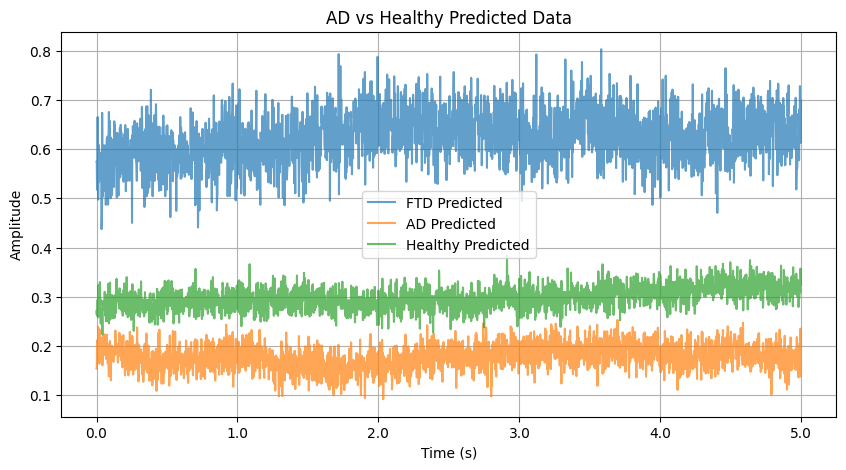

In [6]:
# Plot comparison of predicted data
plt.figure(figsize=(10, 5))
plt.plot(ftd_data['y_pred'][0,:,0], label='FTD Predicted', alpha=0.7)
plt.plot(ad_data['y_pred'][0,:,0], label='AD Predicted', alpha=0.7)
plt.plot(healthy_data['y_pred'][0,:,0], label='Healthy Predicted', alpha=0.7)
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(ad_data['y_pred'][0,:,0])+500, 500), np.arange(0, len(ad_data['y_pred'][0,:,0])+500, 500) / SAMPLING_RATE)
plt.ylabel('Amplitude')
plt.title('AD vs Healthy Predicted Data')
plt.legend()
plt.grid()

## Data Presentation - FFT

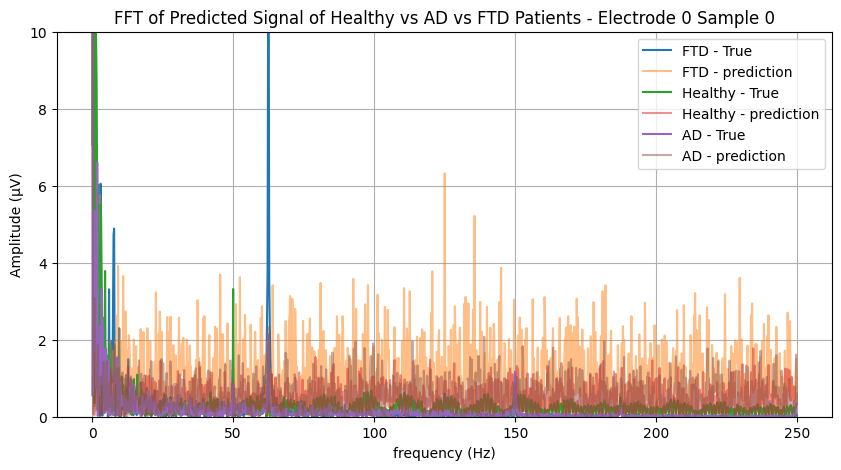

In [7]:
# Plot comparison of AD and Healthy predicted data in fft
sample = 0  # Sample index to plot
electrode = 0  # Electrode index to plot
plt.figure(figsize=(10, 5))
plt.plot(ftd_data['xf'], ftd_data['yf_true'][sample,:,electrode], label='FTD - True')
plt.plot(ftd_data['xf'], ftd_data['yf_pred'][sample,:,electrode], label='FTD - prediction', alpha=0.5)
plt.plot(healthy_data['xf'], healthy_data['yf_true'][sample,:,electrode], label='Healthy - True')
plt.plot(healthy_data['xf'], healthy_data['yf_pred'][sample,:,electrode], label='Healthy - prediction', alpha=0.5)
plt.plot(ad_data['xf'], ad_data['yf_true'][sample,:,electrode], label='AD - True')
plt.plot(ad_data['xf'], ad_data['yf_pred'][sample,:,electrode], label='AD - prediction', alpha=0.5)

plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude (µV)')
plt.title('FFT of Predicted Signal of Healthy vs AD vs FTD Patients - Electrode 0 Sample 0') 
plt.ylim(0, 1e-2)
plt.yticks(np.arange(0, 0.011, 0.002),np.arange(0, 11, 2))
plt.legend()
plt.grid()

Text(0.5, 0.98, 'FFT of Predicted Signal of Healthy vs AD vs FTD Patients - Electrode Fp1 ')

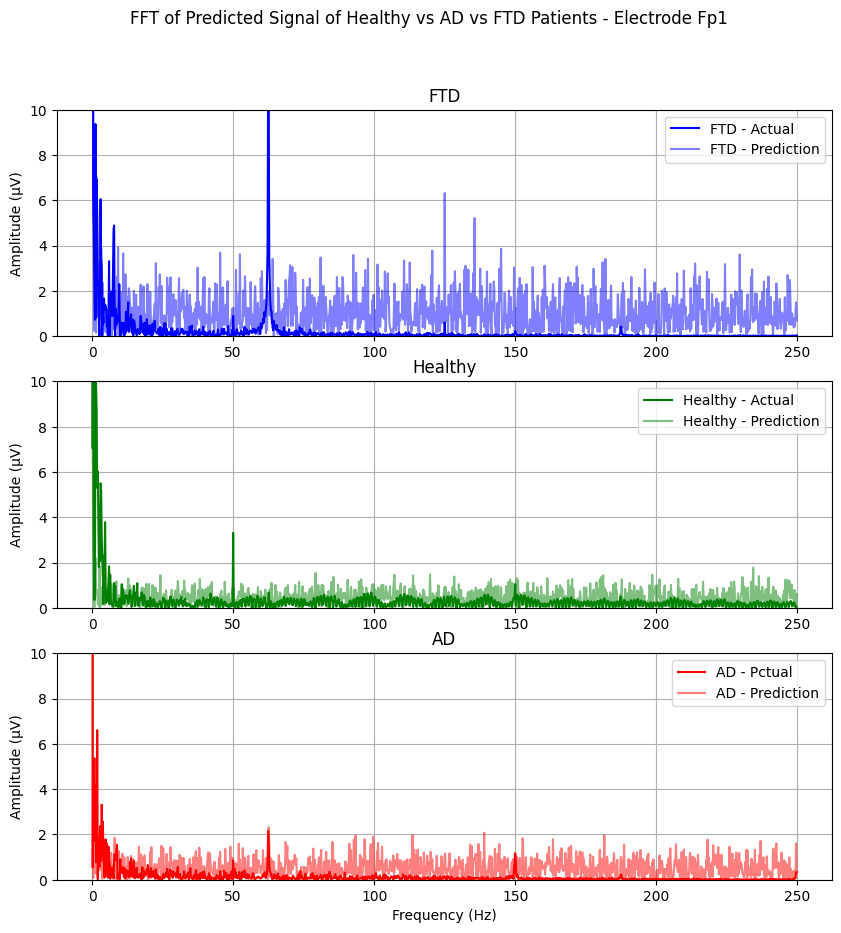

In [8]:
# Plot comparison of AD and Healthy predicted data in fft
sample = 0  # Sample index to plot
electrode = 0  # Electrode index to plot
electrode_name = ELECTRODES[electrode]
f, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(ftd_data['xf'], ftd_data['yf_true'][sample,:,electrode], label='FTD - Actual', color ='blue')
ax[0].plot(ftd_data['xf'], ftd_data['yf_pred'][sample,:,electrode], label='FTD - Prediction', alpha=0.5, color ='blue')
ax[1].plot(healthy_data['xf'], healthy_data['yf_true'][sample,:,electrode], label='Healthy - Actual', color ='green')
ax[1].plot(healthy_data['xf'], healthy_data['yf_pred'][sample,:,electrode], label='Healthy - Prediction', alpha=0.5, color ='green')
ax[2].plot(ad_data['xf'], ad_data['yf_true'][sample,:,electrode], label='AD - Pctual', color ='red')
ax[2].plot(ad_data['xf'], ad_data['yf_pred'][sample,:,electrode], label='AD - Prediction', alpha=0.5, color ='red')
ax[0].set_title('FTD')
ax[1].set_title('Healthy')
ax[2].set_title('AD')
for i in range(3):
    ax[i].set_ylabel('Amplitude (µV)')
    ax[i].set_ylim(0, 1e-2)
    ax[i].set_yticks(np.arange(0, 0.011, 0.002),np.arange(0, 11, 2))
    ax[i].legend()
    ax[i].grid()

ax[2].set_xlabel('Frequency (Hz)')

#hide the y ticks for the other two plots

f.suptitle(f'FFT of Predicted Signal of Healthy vs AD vs FTD Patients - Electrode {electrode_name} ')



# Commparison of All three groups - Prediction with Model trained on Healthy Patients

Predicted Healthy data shape: (930, 2500, 6)
Predicted AD data with model trained on Healthy pateints shape: (930, 2500, 6)
Predicted FTD with model trained on Healthy pateints data shape: (629, 2500, 6)


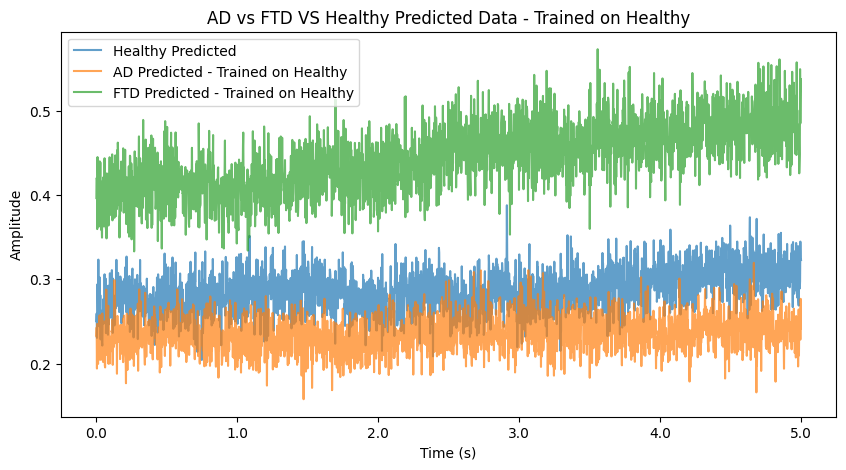

In [9]:
ad_on_healthy_data = {}
ftd_on_healthy_data = {}
for i in data_list:
    ad_on_healthy_data[i] = np.load(f'plots/fft_data_AD_Trained on_Healthy_frontal_electrodes{attempt}.npz')[i]
    ftd_on_healthy_data[i] = np.load(f'plots/fft_data_FTD_Trained on_Healthy_frontal_electrodes{attempt}.npz')[i]
print("Predicted Healthy data shape:", healthy_data['y_pred'].shape)
print("Predicted AD data with model trained on Healthy pateints shape:", ad_on_healthy_data['y_pred'].shape)
print("Predicted FTD with model trained on Healthy pateints data shape:", ftd_on_healthy_data['y_pred'].shape)

sample = 3
# Plot comparison of AD FTD and Healthy patients with healthy trained model predicted data
plt.figure(figsize=(10, 5))
plt.plot(healthy_data['y_pred'][sample,:,0], label='Healthy Predicted', alpha=0.7)
plt.plot(ad_on_healthy_data['y_pred'][sample,:,0], label='AD Predicted - Trained on Healthy', alpha=0.7)
plt.plot(ftd_on_healthy_data['y_pred'][sample,:,0], label='FTD Predicted - Trained on Healthy', alpha=0.7)
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(ad_data['y_pred'][sample,:,0])+500, 500), np.arange(0, len(ad_data['y_pred'][sample,:,0])+500, 500) / SAMPLING_RATE)
plt.ylabel('Amplitude')
plt.title('AD vs FTD VS Healthy Predicted Data - Trained on Healthy')
plt.legend()


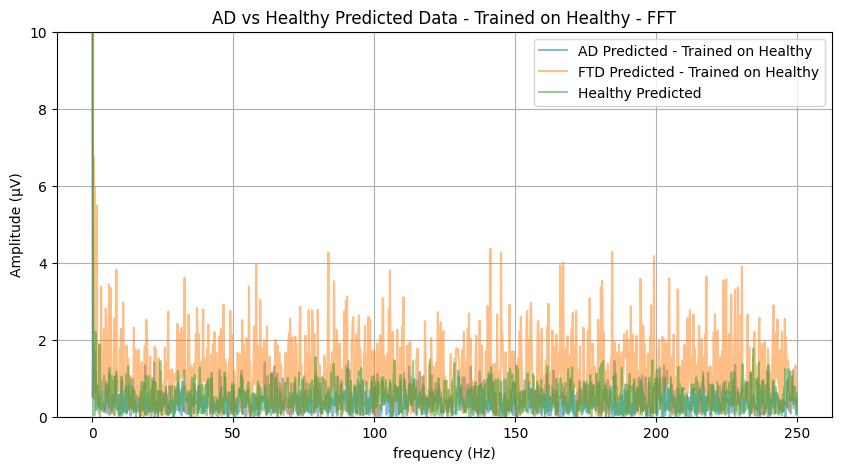

In [10]:
sample_fft = 0
# Plot comparison of AD FTD and Healthy patients with healthy trained model predicted data - fft
plt.figure(figsize=(10, 5))
plt.plot(ad_on_healthy_data['xf'], ad_on_healthy_data['yf_pred'][sample_fft,:,0], label='AD Predicted - Trained on Healthy', alpha=0.5)
plt.plot(ftd_on_healthy_data['xf'], ftd_on_healthy_data['yf_pred'][sample_fft,:,0], label='FTD Predicted - Trained on Healthy', alpha=0.5)
plt.plot(healthy_data['xf'], healthy_data['yf_pred'][sample_fft,:,0], label='Healthy Predicted', alpha=0.5)
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude (µV)')
plt.title('AD vs Healthy Predicted Data - Trained on Healthy - FFT')
plt.ylim(0, 1e-2)
plt.yticks(np.arange(0, 0.011, 0.002),np.arange(0, 11, 2))
plt.legend()
plt.grid()